# QRNN Classification

This notebook uses the QRNN trained on GPM surface precipitation to classify raining and non-raining pixels.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np

# Load QRNN and data

In [2]:
from typhon.retrieval.qrnn import QRNN
qrnn = QRNN.load("qrnn_6_128.pt")
qrnn_log = QRNN.load("qrnn_6_128_log.pt")

Using TensorFlow backend.


In [3]:
from regn.data import GprofData
test_data = GprofData("../../data/validation_data_small.nc",
                      batch_size=32,
                      normalization_data="normalization_data.nc")
test_data_log = GprofData("../../data/validation_data_small.nc",
                          batch_size=32,
                          normalization_data="normalization_data.nc",
                          log_rain_rates=True)

# Classify test data

In [4]:
def evaluate(model, data, threshold=0.1):
    """
    Compute rain probability on test set.
    
    Args:
        model: QRNN to predict probabilities.
        data: Pytorch dataset providing access to the test data.
    Returns:
        Tuple (p, y_true) of predicted probabilities p for the
        observations to be above the given threshold and the corresponding
        true binary label (raining or non-raining).
    """
    p = []
    y_true = []
    y_pred = []
    for i in range(len(data)):
        x, y = data[i]
        y_true.append(y)
        y_pred.append(model.predict(x))
        p.append(model.classify(x, threshold))
    p = np.concatenate(p, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_true = y_true > threshold
    return p, y_true

In [5]:
p, y_true = evaluate(qrnn, test_data)
p_log, y_true_log = evaluate(qrnn_log, test_data_log, np.log10(0.1))

## Evaluate performance

In [6]:
from regn.utils import compute_roc
fpr, tpr = compute_roc(p.ravel(), y_true.ravel(), np.linspace(0, 1, 101))
fpr_log, tpr_log = compute_roc(p_log.ravel(), y_true_log.ravel(), np.linspace(0, 1, 101))

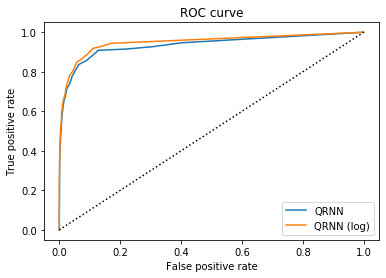

In [7]:
plt.plot(fpr, tpr, label="QRNN")
plt.plot(fpr_log, tpr_log, label="QRNN (log)")
x = np.linspace(0, 1, 1001)
plt.plot(x, x, ls = ":", c = "k")
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()